In [33]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene as pv

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

In [34]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from collections import namedtuple
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import pandas as pd

In [35]:
animals = [
    ("cats", "cat"),
    ("wolves", "wolf"),
    ("mice", "mouse"),
    ("sheep", "sheep"),
    ("lions", "lion"),
    ("tigers", "tiger"),
    ("horses", "horse"),
    ("dogs", "dog"),
    ("birds", "bird"),
    ("cows", "cow"),
    ("snakes", "snake"),
    ("frogs", "frog"),
    ("fish", "fish"),
    ("bears", "bear"),
    ("pigs", "pig"),
    ("chickens", "chicken"),
    ("ducks", "duck"),
    ("bees", "bee"),
    ("spiders", "spider"),
    ("butterflies", "butterfly"),
    ("worms", "worm"),
    ("flies", "fly"),
    ("mosquitoes", "mosquito"),
    ("beetles", "beetle"),
    ("crickets", "cricket"),
    ("grasshoppers", "grasshopper"),
    ("ladybugs", "ladybug"),
]

In [36]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model_size = "70m"
model = f"EleutherAI/pythia-{model_size}"  # "EleutherAI/pythia-6.9B"
tokenizer = AutoTokenizer.from_pretrained(model)
gpt = AutoModelForCausalLM.from_pretrained(
    model,
    revision="main",
    torch_dtype=torch.bfloat16 if model == "EleutherAI/pythia-6.9b" else torch.float32,
).to(device)

In [37]:
# only animals with 1 token in plural and singular form
token_length_matching_animals = []

for plural_animal, singular_animal in animals:
    tokenized_plural = tokenizer.tokenize(plural_animal)
    tokenized_singular = tokenizer.tokenize(singular_animal)

    if len(tokenized_plural) == len(tokenized_singular) and len(tokenized_plural) == 1:
        token_length_matching_animals.append((plural_animal, singular_animal))

token_length_matching_animals

[('cats', 'cat'), ('birds', 'bird'), ('fish', 'fish'), ('flies', 'fly')]

In [38]:
Example = namedtuple("Example", ["base", "base_label"])

names = [
    "Donald",
    "Gary",
    "Deborah",
    "Nancy",
    "Diane",
    "Peter",
    "Kevin",
    "Daniel",
    "Roger",
    "Ralph",
    "Linda",
    "Keith",
    "Paul",
    "Willie",
    "Denise",
    "Marie",
    "Terry",
    "Kayla",
    "Elizabeth",
    "Kelly",
    "Gabriel",
    "Cynthia",
    "Joseph",
    "Harold",
    "Frances",
    "Andrew",
    "Alexis",
    "Bradley",
    "James",
    "Thomas",
    "Jason",
    "Michael",
    "Gregory",
    "Sean",
    "Vincent",
    "Justin",
    "Janet",
    "Sarah",
    "Andrea",
    "Amy",
    "Joan",
    "Kimberly",
    "Natalie",
    "Gerald",
    "Edward",
    "Lisa",
    "Marilyn",
    "Ronald",
    "Victoria",
    "Eugene",
    "Christina",
    "Samantha",
    "Matthew",
    "Douglas",
    "Kenneth",
    "Sophia",
    "Barbara",
    "Margaret",
    "Hannah",
    "Ryan",
    "Megan",
    "Sandra",
    "Robert",
    "Madison",
    "Carolyn",
    "Amanda",
    "Scott",
    "Anthony",
    "Mary",
    "Eric",
    "William",
    "Lawrence",
    "Christian",
    "Lori",
    "Henry",
    "Betty",
    "Dorothy",
    "Samuel",
    "Stephanie",
    "Teresa",
    "Nicole",
    "Julia",
    "Rebecca",
    "Mason",
    "Julie",
    "Emma",
    "Jeremy",
    "Olivia",
    "Larry",
    "Juan",
    "Adam",
    "Alice",
    "Amber",
    "Joe",
    "Angela",
    "Sara",
    "Judy",
    "Christopher",
    "Raymond",
    "Jordan",
    "Karen",
    "Stephen",
    "Kathleen",
    "Billy",
    "Rachel",
    "Diana",
    "Emily",
    "Debra",
    "Roy",
    "Susan",
    "Bobby",
    "Gloria",
    "Doris",
    "Patricia",
    "Ethan",
    "Bruce",
    "David",
    "Richard",
    "Judith",
    "Michelle",
    "Timothy",
    "Frank",
    "Philip",
    "Melissa",
    "Cheryl",
    "Isabella",
    "Jack",
    "Randy",
    "Danielle",
    "Jennifer",
    "Kyle",
    "Walter",
    "Austin",
    "Janice",
    "Sharon",
    "Jean",
    "Steven",
    "Russell",
    "Christine",
    "Theresa",
    "Katherine",
    "Maria",
    "Jesse",
    "Ann",
    "Arthur",
    "Brandon",
    "Jose",
    "Carol",
    "Jacqueline",
    "Joyce",
    "George",
    "Alexander",
    "Patrick",
    "Zachary",
    "Carl",
    "Beverly",
    "Evelyn",
    "Virginia",
    "Charlotte",
    "Jonathan",
    "Laura",
    "John",
    "Charles",
    "Brian",
    "Nicholas",
    "Dylan",
    "Tyler",
    "Jeffrey",
    "Jessica",
    "Helen",
    "Logan",
    "Martha",
    "Albert",
    "Jerry",
    "Nathan",
    "Brenda",
    "Ruth",
    "Donna",
    "Brittany",
    "Shirley",
    "Pamela",
    "Catherine",
    "Lauren",
    "Abigail",
    "Kathryn",
    "Noah",
    "Aaron",
    "Bryan",
    "Grace",
    "Elijah",
    "Heather",
    "Alan",
    "Mark",
    "Wayne",
    "Jacob",
    "Ashley",
    "Benjamin",
    "Joshua",
    "Dennis",
    "Anna",
]

names = [name for name in names if len(tokenizer.tokenize(name)) == 1]

In [39]:
import itertools
import pprint
import numpy as np


def create_variations_no_replacement(collection, size):
    combinations = list(itertools.combinations(collection, size))
    variations_nested_list = list(
        map(lambda x: list(itertools.permutations(x)), combinations)
    )
    flattened_list = list(itertools.chain(*variations_nested_list))
    return flattened_list

In [40]:
# example: A_1 are afraid of A_2. A_3 are afraid of A_4. N_1 is a A_1. N_1 is afraid of... (A_2)
def create_examples():
    examples = []
    variations = create_variations_no_replacement(token_length_matching_animals, 4)
    for variation in variations:
        A_1, A_2, A_3, A_4 = variation
        for name in names:
            sentence = f"<|endoftext|>{A_1[0]} are afraid of {A_2[0]}. {A_3[0]} are afraid of {A_4[0]}. {name} is a {A_1[1]}. {name} is afraid of"
            label = f"{A_2[0]}"

            base = tokenizer(
                sentence,
                return_tensors="pt",
            )
            base_label = tokenizer.encode(" " + label)[0]

            examples.append(Example(base, base_label))

    return examples


all_examples = create_examples()

In [41]:
from tqdm import tqdm


def generate_n_doable_examples(n, model):
    examples = []
    iterator = tqdm(range(n))
    random.seed(42)
    random.shuffle(all_examples)
    data_iterator = iter(all_examples)
    while len(examples) < n:
        ex = data_iterator.__next__()

        for k, v in ex.base.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.base[k] = v.to(model.device)
        logits_base = model(**ex.base).logits[0, -1]
        argmax_base = torch.argmax(logits_base).item()
        # relaxing problem to pass only if the model predicts the correct token without comparing with base
        if argmax_base == ex.base_label:
            examples.append(ex)
            iterator.update(1)
    return examples


total_steps = 150
dataset = generate_n_doable_examples(total_steps, gpt)
trainset = dataset[:100]
evalset = dataset[100:]

100%|██████████| 150/150 [00:01<00:00, 97.49it/s] 


In [42]:
print(tokenizer.decode(trainset[0].base.input_ids[0]))
print(tokenizer.decode(gpt(**trainset[0].base).logits[0, -1].argmax().item()))

<|endoftext|>fish are afraid of cats. flies are afraid of birds. Maria is a fish. Maria is afraid of
 cats


In [43]:
def probing_config(intervention_site, layer):
    """Generate intervention config."""

    # init
    config = pv.IntervenableConfig(
        [
            {
                "layer": layer,
                "component": intervention_site,
                "intervention_type": pv.CollectIntervention,
            }
        ]
    )
    return config

In [44]:
labels_set = set()
for item in dataset:
    decoded = tokenizer.decode(item.base_label)
    labels_set.add(decoded)
print(labels_set)

{' cats', ' birds'}


In [45]:
labels = [" birds", " cats"]


for label in labels:
    print("Label: ", label, "id: ", tokenizer(label).input_ids[0])

Label:   birds id:  11260
Label:   cats id:  16581


In [46]:
# intervention settings
stats = []
num_layers = gpt.config.num_hidden_layers

# 11260 = " birds", 16581 = " cats"
label_mapping = {11260: 0, 16581: 1}

sample_length_in_tokens = 22

# loop over layers and positions
with torch.no_grad():
    for layer in range(num_layers):
        for position in range(sample_length_in_tokens):
            print(f"layer: {layer}, position: {position}")

            # set up intervenable model
            config = probing_config("block_output", layer)
            intervenable = pv.IntervenableModel(config, gpt)
            intervenable.set_device(device)
            intervenable.disable_model_gradients()

            # training loop
            activations, labels = [], []
            iterator = tqdm(trainset)
            for example in iterator:
                # forward pass
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": position},
                )
                base_activations = base_outputs[1][0]

                # collect activation
                activations.extend(
                    [
                        base_activations.detach()[0].cpu().numpy(),
                    ]
                )
                labels.extend([example.base_label])
            labels = [label_mapping[label] for label in labels]

            # train logistic regression
            lr = LogisticRegression(random_state=42, max_iter=1000).fit(
                activations, labels
            )

            # eval
            activations, labels = [], []
            iterator = tqdm(evalset)
            for example in iterator:
                # forward pass
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": position},
                )
                base_activations = base_outputs[1][0]

                # collect activation
                activations.extend(
                    [
                        base_activations.detach()[0].cpu().numpy(),
                    ]
                )
                labels.extend([example.base_label])
            labels = [label_mapping[label] for label in labels]

            # stats
            acc = lr.score(activations, labels)
            f1 = f1_score(labels, lr.predict(activations))
            stats.append({"layer": layer, "position": position, "acc": acc, "f1": f1})
            print(f"acc: {acc:.3%}, f1: {f1:.3f}")
df = pd.DataFrame(stats)
df.to_csv(f"./pyvene_babi_nli_deduction_{model_size}.csv")

layer: 0, position: 0


100%|██████████| 50/50 [00:00<00:00, 344.44it/s]


acc: 60.000%, f1: 0.750
layer: 0, position: 1


100%|██████████| 50/50 [00:00<00:00, 346.94it/s]


acc: 82.000%, f1: 0.870
layer: 0, position: 2


100%|██████████| 50/50 [00:00<00:00, 350.03it/s]


acc: 82.000%, f1: 0.870
layer: 0, position: 3


100%|██████████| 50/50 [00:00<00:00, 352.96it/s]


acc: 82.000%, f1: 0.870
layer: 0, position: 4


100%|██████████| 50/50 [00:00<00:00, 353.88it/s]


acc: 60.000%, f1: 0.750
layer: 0, position: 5


100%|██████████| 50/50 [00:00<00:00, 329.83it/s]


acc: 100.000%, f1: 1.000
layer: 0, position: 6


100%|██████████| 50/50 [00:00<00:00, 349.72it/s]


acc: 78.000%, f1: 0.845
layer: 0, position: 7


100%|██████████| 50/50 [00:00<00:00, 349.80it/s]


acc: 98.000%, f1: 0.984
layer: 0, position: 8


100%|██████████| 50/50 [00:00<00:00, 353.65it/s]


acc: 78.000%, f1: 0.845
layer: 0, position: 9


100%|██████████| 50/50 [00:00<00:00, 344.39it/s]


acc: 78.000%, f1: 0.845
layer: 0, position: 10


100%|██████████| 50/50 [00:00<00:00, 330.49it/s]


acc: 60.000%, f1: 0.750
layer: 0, position: 11


100%|██████████| 50/50 [00:00<00:00, 348.45it/s]


acc: 68.000%, f1: 0.652
layer: 0, position: 12


100%|██████████| 50/50 [00:00<00:00, 349.71it/s]


acc: 60.000%, f1: 0.750
layer: 0, position: 13


100%|██████████| 50/50 [00:00<00:00, 350.91it/s]


acc: 50.000%, f1: 0.590
layer: 0, position: 14


100%|██████████| 50/50 [00:00<00:00, 343.77it/s]


acc: 60.000%, f1: 0.750
layer: 0, position: 15


100%|██████████| 50/50 [00:00<00:00, 321.16it/s]


acc: 60.000%, f1: 0.750
layer: 0, position: 16


100%|██████████| 50/50 [00:00<00:00, 347.72it/s]


acc: 82.000%, f1: 0.870
layer: 0, position: 17


100%|██████████| 50/50 [00:00<00:00, 325.93it/s]


acc: 82.000%, f1: 0.870
layer: 0, position: 18


100%|██████████| 50/50 [00:00<00:00, 342.55it/s]


acc: 52.000%, f1: 0.600
layer: 0, position: 19


100%|██████████| 50/50 [00:00<00:00, 325.79it/s]


acc: 64.000%, f1: 0.763
layer: 0, position: 20


100%|██████████| 50/50 [00:00<00:00, 345.97it/s]


acc: 60.000%, f1: 0.750
layer: 0, position: 21


100%|██████████| 50/50 [00:00<00:00, 352.42it/s]


acc: 60.000%, f1: 0.750
layer: 1, position: 0


100%|██████████| 50/50 [00:00<00:00, 353.80it/s]


acc: 60.000%, f1: 0.750
layer: 1, position: 1


100%|██████████| 50/50 [00:00<00:00, 349.71it/s]


acc: 82.000%, f1: 0.870
layer: 1, position: 2


100%|██████████| 50/50 [00:00<00:00, 355.35it/s]


acc: 82.000%, f1: 0.870
layer: 1, position: 3


100%|██████████| 50/50 [00:00<00:00, 339.77it/s]


acc: 82.000%, f1: 0.870
layer: 1, position: 4


100%|██████████| 50/50 [00:00<00:00, 350.57it/s]


acc: 82.000%, f1: 0.870
layer: 1, position: 5


100%|██████████| 50/50 [00:00<00:00, 354.18it/s]


acc: 100.000%, f1: 1.000
layer: 1, position: 6


100%|██████████| 50/50 [00:00<00:00, 344.36it/s]


acc: 100.000%, f1: 1.000
layer: 1, position: 7


100%|██████████| 50/50 [00:00<00:00, 342.78it/s]


acc: 98.000%, f1: 0.984
layer: 1, position: 8


100%|██████████| 50/50 [00:00<00:00, 338.48it/s]


acc: 98.000%, f1: 0.984
layer: 1, position: 9


100%|██████████| 50/50 [00:00<00:00, 329.61it/s]


acc: 98.000%, f1: 0.984
layer: 1, position: 10


100%|██████████| 50/50 [00:00<00:00, 338.94it/s]


acc: 78.000%, f1: 0.845
layer: 1, position: 11


100%|██████████| 50/50 [00:00<00:00, 343.59it/s]


acc: 86.000%, f1: 0.868
layer: 1, position: 12


100%|██████████| 50/50 [00:00<00:00, 329.54it/s]


acc: 80.000%, f1: 0.857
layer: 1, position: 13


100%|██████████| 50/50 [00:00<00:00, 347.15it/s]


acc: 50.000%, f1: 0.590
layer: 1, position: 14


100%|██████████| 50/50 [00:00<00:00, 347.52it/s]


acc: 62.000%, f1: 0.740
layer: 1, position: 15


100%|██████████| 50/50 [00:00<00:00, 354.99it/s]


acc: 62.000%, f1: 0.759
layer: 1, position: 16


100%|██████████| 50/50 [00:00<00:00, 356.72it/s]


acc: 82.000%, f1: 0.870
layer: 1, position: 17


100%|██████████| 50/50 [00:00<00:00, 353.50it/s]


acc: 82.000%, f1: 0.870
layer: 1, position: 18


100%|██████████| 50/50 [00:00<00:00, 357.00it/s]


acc: 66.000%, f1: 0.730
layer: 1, position: 19


100%|██████████| 50/50 [00:00<00:00, 355.00it/s]


acc: 82.000%, f1: 0.870
layer: 1, position: 20


100%|██████████| 50/50 [00:00<00:00, 300.47it/s]


acc: 80.000%, f1: 0.857
layer: 1, position: 21


100%|██████████| 50/50 [00:00<00:00, 356.25it/s]


acc: 74.000%, f1: 0.822
layer: 2, position: 0


100%|██████████| 50/50 [00:00<00:00, 357.06it/s]


acc: 60.000%, f1: 0.750
layer: 2, position: 1


100%|██████████| 50/50 [00:00<00:00, 350.85it/s]


acc: 82.000%, f1: 0.870
layer: 2, position: 2


100%|██████████| 50/50 [00:00<00:00, 349.21it/s]


acc: 82.000%, f1: 0.870
layer: 2, position: 3


100%|██████████| 50/50 [00:00<00:00, 329.31it/s]


acc: 82.000%, f1: 0.870
layer: 2, position: 4


100%|██████████| 50/50 [00:00<00:00, 328.32it/s]


acc: 82.000%, f1: 0.870
layer: 2, position: 5


100%|██████████| 50/50 [00:00<00:00, 347.99it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 6


100%|██████████| 50/50 [00:00<00:00, 345.59it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 7


100%|██████████| 50/50 [00:00<00:00, 329.68it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 8


100%|██████████| 50/50 [00:00<00:00, 341.87it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 9


100%|██████████| 50/50 [00:00<00:00, 349.44it/s]


acc: 98.000%, f1: 0.984
layer: 2, position: 10


100%|██████████| 50/50 [00:00<00:00, 351.25it/s]


acc: 98.000%, f1: 0.984
layer: 2, position: 11


100%|██████████| 50/50 [00:00<00:00, 348.86it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 12


100%|██████████| 50/50 [00:00<00:00, 344.21it/s]


acc: 100.000%, f1: 1.000
layer: 2, position: 13


100%|██████████| 50/50 [00:00<00:00, 257.23it/s]


acc: 64.000%, f1: 0.690
layer: 2, position: 14


100%|██████████| 50/50 [00:00<00:00, 349.43it/s]


acc: 66.000%, f1: 0.721
layer: 2, position: 15


100%|██████████| 50/50 [00:00<00:00, 352.01it/s]


acc: 70.000%, f1: 0.762
layer: 2, position: 16


100%|██████████| 50/50 [00:00<00:00, 324.10it/s]


acc: 90.000%, f1: 0.921
layer: 2, position: 17


100%|██████████| 50/50 [00:00<00:00, 352.54it/s]


acc: 82.000%, f1: 0.862
layer: 2, position: 18


100%|██████████| 50/50 [00:00<00:00, 353.06it/s]


acc: 76.000%, f1: 0.806
layer: 2, position: 19


100%|██████████| 50/50 [00:00<00:00, 346.00it/s]


acc: 76.000%, f1: 0.818
layer: 2, position: 20


100%|██████████| 50/50 [00:00<00:00, 307.38it/s]


acc: 78.000%, f1: 0.831
layer: 2, position: 21


100%|██████████| 50/50 [00:00<00:00, 350.20it/s]


acc: 80.000%, f1: 0.853
layer: 3, position: 0


100%|██████████| 50/50 [00:00<00:00, 302.84it/s]


acc: 60.000%, f1: 0.750
layer: 3, position: 1


100%|██████████| 50/50 [00:00<00:00, 304.76it/s]


acc: 82.000%, f1: 0.870
layer: 3, position: 2


100%|██████████| 50/50 [00:00<00:00, 355.95it/s]


acc: 82.000%, f1: 0.870
layer: 3, position: 3


100%|██████████| 50/50 [00:00<00:00, 352.22it/s]


acc: 82.000%, f1: 0.870
layer: 3, position: 4


100%|██████████| 50/50 [00:00<00:00, 347.64it/s]


acc: 82.000%, f1: 0.870
layer: 3, position: 5


100%|██████████| 50/50 [00:00<00:00, 318.08it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 6


100%|██████████| 50/50 [00:00<00:00, 339.21it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 7


100%|██████████| 50/50 [00:00<00:00, 337.17it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 8


100%|██████████| 50/50 [00:00<00:00, 366.28it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 9


100%|██████████| 50/50 [00:00<00:00, 338.26it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 10


100%|██████████| 50/50 [00:00<00:00, 296.04it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 11


100%|██████████| 50/50 [00:00<00:00, 346.01it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 12


100%|██████████| 50/50 [00:00<00:00, 350.60it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 13


100%|██████████| 50/50 [00:00<00:00, 346.86it/s]


acc: 62.000%, f1: 0.689
layer: 3, position: 14


100%|██████████| 50/50 [00:00<00:00, 295.29it/s]


acc: 88.000%, f1: 0.903
layer: 3, position: 15


100%|██████████| 50/50 [00:00<00:00, 338.77it/s]


acc: 90.000%, f1: 0.923
layer: 3, position: 16


100%|██████████| 50/50 [00:00<00:00, 311.75it/s]


acc: 98.000%, f1: 0.984
layer: 3, position: 17


100%|██████████| 50/50 [00:00<00:00, 339.35it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 18


100%|██████████| 50/50 [00:00<00:00, 312.42it/s]


acc: 76.000%, f1: 0.800
layer: 3, position: 19


100%|██████████| 50/50 [00:00<00:00, 348.80it/s]


acc: 82.000%, f1: 0.866
layer: 3, position: 20


100%|██████████| 50/50 [00:00<00:00, 299.33it/s]


acc: 100.000%, f1: 1.000
layer: 3, position: 21


100%|██████████| 50/50 [00:00<00:00, 388.95it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 0


100%|██████████| 50/50 [00:00<00:00, 342.53it/s]


acc: 60.000%, f1: 0.750
layer: 4, position: 1


100%|██████████| 50/50 [00:00<00:00, 338.09it/s]


acc: 82.000%, f1: 0.870
layer: 4, position: 2


100%|██████████| 50/50 [00:00<00:00, 335.66it/s]


acc: 82.000%, f1: 0.870
layer: 4, position: 3


100%|██████████| 50/50 [00:00<00:00, 333.36it/s]


acc: 82.000%, f1: 0.870
layer: 4, position: 4


100%|██████████| 50/50 [00:00<00:00, 320.93it/s]


acc: 82.000%, f1: 0.870
layer: 4, position: 5


100%|██████████| 50/50 [00:00<00:00, 322.06it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 6


100%|██████████| 50/50 [00:00<00:00, 335.03it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 7


100%|██████████| 50/50 [00:00<00:00, 328.24it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 8


100%|██████████| 50/50 [00:00<00:00, 342.21it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 9


100%|██████████| 50/50 [00:00<00:00, 348.63it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 10


100%|██████████| 50/50 [00:00<00:00, 353.59it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 11


100%|██████████| 50/50 [00:00<00:00, 353.17it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 12


100%|██████████| 50/50 [00:00<00:00, 330.85it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 13


100%|██████████| 50/50 [00:00<00:00, 341.55it/s]


acc: 66.000%, f1: 0.721
layer: 4, position: 14


100%|██████████| 50/50 [00:00<00:00, 303.51it/s]


acc: 86.000%, f1: 0.889
layer: 4, position: 15


100%|██████████| 50/50 [00:00<00:00, 334.06it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 16


100%|██████████| 50/50 [00:00<00:00, 352.75it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 17


100%|██████████| 50/50 [00:00<00:00, 348.50it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 18


100%|██████████| 50/50 [00:00<00:00, 351.52it/s]


acc: 82.000%, f1: 0.852
layer: 4, position: 19


100%|██████████| 50/50 [00:00<00:00, 357.16it/s]


acc: 86.000%, f1: 0.889
layer: 4, position: 20


100%|██████████| 50/50 [00:00<00:00, 330.68it/s]


acc: 100.000%, f1: 1.000
layer: 4, position: 21


100%|██████████| 50/50 [00:00<00:00, 337.43it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 0


100%|██████████| 50/50 [00:00<00:00, 364.55it/s]


acc: 60.000%, f1: 0.750
layer: 5, position: 1


100%|██████████| 50/50 [00:00<00:00, 360.68it/s]


acc: 82.000%, f1: 0.870
layer: 5, position: 2


100%|██████████| 50/50 [00:00<00:00, 362.05it/s]


acc: 82.000%, f1: 0.870
layer: 5, position: 3


100%|██████████| 50/50 [00:00<00:00, 322.71it/s]


acc: 82.000%, f1: 0.870
layer: 5, position: 4


100%|██████████| 50/50 [00:00<00:00, 358.08it/s]


acc: 82.000%, f1: 0.870
layer: 5, position: 5


100%|██████████| 50/50 [00:00<00:00, 350.74it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 6


100%|██████████| 50/50 [00:00<00:00, 355.43it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 7


100%|██████████| 50/50 [00:00<00:00, 365.16it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 8


100%|██████████| 50/50 [00:00<00:00, 345.31it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 9


100%|██████████| 50/50 [00:00<00:00, 357.94it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 10


100%|██████████| 50/50 [00:00<00:00, 351.70it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 11


100%|██████████| 50/50 [00:00<00:00, 385.48it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 12


100%|██████████| 50/50 [00:00<00:00, 348.52it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 13


100%|██████████| 50/50 [00:00<00:00, 357.46it/s]


acc: 70.000%, f1: 0.754
layer: 5, position: 14


100%|██████████| 50/50 [00:00<00:00, 305.00it/s]


acc: 94.000%, f1: 0.952
layer: 5, position: 15


100%|██████████| 50/50 [00:00<00:00, 357.65it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 16


100%|██████████| 50/50 [00:00<00:00, 356.16it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 17


100%|██████████| 50/50 [00:00<00:00, 354.01it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 18


100%|██████████| 50/50 [00:00<00:00, 359.58it/s]


acc: 90.000%, f1: 0.921
layer: 5, position: 19


100%|██████████| 50/50 [00:00<00:00, 339.29it/s]


acc: 96.000%, f1: 0.968
layer: 5, position: 20


100%|██████████| 50/50 [00:00<00:00, 331.24it/s]


acc: 100.000%, f1: 1.000
layer: 5, position: 21


100%|██████████| 50/50 [00:00<00:00, 356.12it/s]

acc: 100.000%, f1: 1.000


/mnt/m2-mint/nlp-winter2024/env/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/m2-mint/nlp-winter2024/env/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./pyvene_babi_nli_deduction_70m.pdf


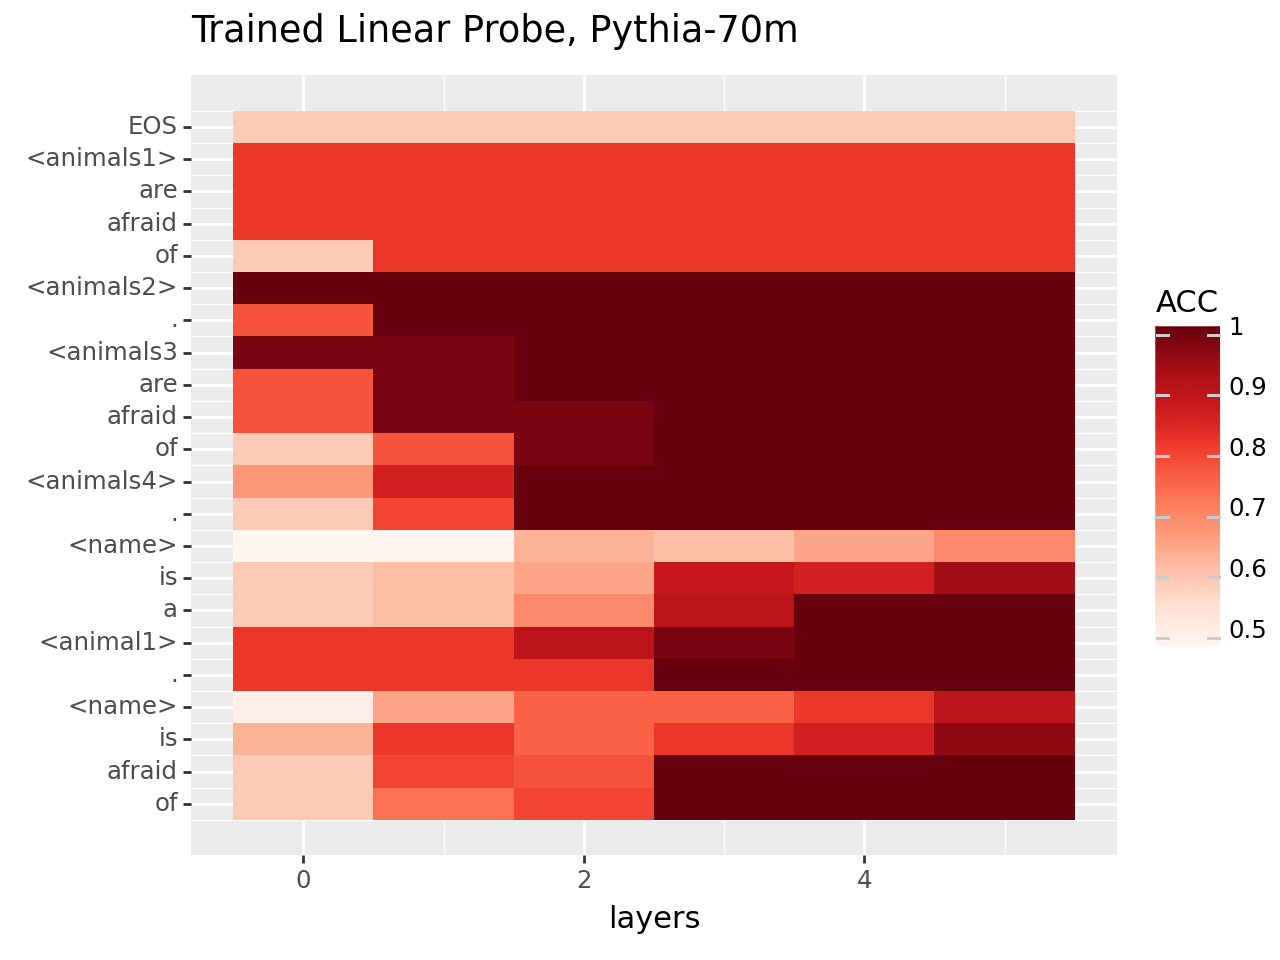

In [47]:
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    geom_line,
    geom_point,
    geom_text,
    ggtitle,
    xlab,
    ylab,
    ggsave,
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap

df = pd.read_csv(f"./pyvene_babi_nli_deduction_{model_size}.csv")
df["layer"] = df["layer"].astype(int)
df["pos"] = df["position"].astype(int)
df["ACC"] = df["acc"].astype(float)

custom_labels = [
    "EOS",
    "<animals1>",
    "are",
    "afraid",
    "of",
    "<animals2>",
    ".",
    "<animals3",
    "are",
    "afraid",
    "of",
    "<animals4>",
    ".",
    "<name>",
    "is",
    "a",
    "<animal1>",
    ".",
    "<name>",
    "is",
    "afraid",
    "of",
]
breaks = list(range(len(custom_labels)))

plot = (
    ggplot(df, aes(x="layer", y="pos", fill="ACC"))
    + geom_tile()
    + scale_fill_cmap("Reds")
    + xlab("layers")
    + scale_y_reverse(breaks=breaks, labels=custom_labels)
    + ylab("")
    + theme(axis_text_y=element_text(angle=0, hjust=1))
    + ggtitle(f"Trained Linear Probe, Pythia-{model_size}")
)
ggsave(plot, filename=f"./pyvene_babi_nli_deduction_{model_size}.pdf", dpi=200)
print(plot)